##libraries
Google drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# libraries
import pandas as pd
import numpy as np
import ast
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

---
# Extrinsic Evaluation
* keyword 추출 모델의 성능은 `ROUGE` score로 평가
* topic 추출 결과의 성능은 `cosine similarity` 및 `co-herence` 지표로 평가


## keyword extraction models
* 우리가 시도했던 TextRank, YAKE!, keyBERT, BERTopic 4개 모델로 일부 라벨링된 문장들로부터 keyword를 추출
* 라벨링은 직접 50개 문장을 랜덤 추출하여 수행
* 4개 결과를 가지고 ROUGE, F1 score를 도출해냄

In [ ]:
# 라벨링한 데이터셋
url = '추가 예정'
eval = pd.read_csv(url)

In [ ]:
eval.columns

Index(['review_id', 'stars', 'sentence', 'label_ug', 'label_bg', 'keywords_ug',
       'keywords_bg', 'topic'],
      dtype='object')

In [ ]:
eval_sen = eval['sentence'].to_list()  # 평가할 문장들 리스트

### 1) TEXTRANK


In [ ]:
from nltk.tokenize import PunktSentenceTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
from collections import Counter
from collections import defaultdict
import networkx as nx
from nltk.util import ngrams

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# 전처리 함수
def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    # 특수문자 제거
    text = re.sub(r'\W', ' ', text)
    # 토큰화
    words = word_tokenize(text)
    # 불용어 제거
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

# 텍스트 랭크 알고리즘을 사용한 키워드 추출
def textrank_keywords(text, n_keywords=5, ngram_range=(1, 2)):
    words = preprocess_text(text)

    # n-gram 추출
    ngrams_list = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams_list.extend(ngrams(words, n))

    # ngrams_list를 문자열로 변환 (단어들을 공백으로 연결)
    ngrams_list = [' '.join(ngram) for ngram in ngrams_list]

    word_graph = defaultdict(list)

    # 그래프 생성
    for i, word in enumerate(ngrams_list):
        for j in range(i+1, len(ngrams_list)):
            word_graph[word].append(ngrams_list[j])
            word_graph[ngrams_list[j]].append(word)

    graph = nx.Graph(word_graph)

    # PageRank 계산
    scores = nx.pagerank(graph)

    # 상위 n개의 키워드 추출
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    top_keywords = [word for word, score in sorted_scores[:n_keywords]]

    # 리스트가 1개일 경우 리스트가 아닌 문자열로 반환
    if len(top_keywords) == 1:
        return top_keywords[0]
    return top_keywords

In [ ]:
tr_kw_ug = []
tr_kw_bg = []
for sent in eval_sen:
  ug = textrank_keywords(sent, n_keywords=1,  ngram_range=(1, 1))
  bg = textrank_keywords(sent,ngram_range=(1, 2))
  tr_kw_ug.append(ug)
  tr_kw_bg.append(bg)
tr_kw_ug

tr_kw_bg_select = []
for i, kws in enumerate(tr_kw_bg):
  if len(kws) > 0 : # 키워드 있을 경우
    for kw in kws :
      if ' ' in kw : # 공백 있을 경우 = 2gram
        tr_kw_bg_select.append(kw)
        break
    if len(tr_kw_bg_select) < i+1 :  # 2gram 없었으면
      tr_kw_bg_select.append(kws[0]) # 첫번째 키워드 넣기
  else :
    tr_kw_bg_select.append(None)
tr_kw_bg = tr_kw_bg_select # 대체해주기
tr_kw_bg

['spicy',
 'worth 15',
 'great',
 'recommend anyone',
 'surly back',
 'went',
 'everything',
 'person',
 'barely',
 'felt',
 'also',
 'sure',
 'seemed',
 '35',
 'make',
 'said',
 'supposed information',
 'maybe',
 'going nene',
 'best chicken',
 'service always',
 'nothing bad',
 'need',
 'convenient quick',
 'cold beer',
 'server ajna',
 'always willing',
 'disappointed today',
 'one',
 'ingredient great',
 'need',
 'donut',
 'folk running',
 'love pana',
 'super',
 'first time',
 'got',
 'give',
 None,
 'pleasantly satisfied',
 'friday',
 'loved',
 'miss red',
 'dance live',
 'best jimmy',
 'cat',
 'sandwich',
 'freakin awesome',
 'time',
 'tried']

In [ ]:
# df에 추가
eval['tr_kw_ug'] = tr_kw_ug
eval['tr_kw_bg'] = tr_kw_bg
eval.drop(columns='stars', inplace=True)
eval

,review_id,sentence,label_ug,label_bg,keywords_ug,keywords_bg,topic,tr_kw_ug,tr_kw_bg
0,3579484,"Tried the large 4 scoop with brown rice, for p...",combo,great combo,spice,spicy tuna,food,spicy,spicy
1,3579484,So worth the $15!,worth,worth,worth,worth 15,price,worth,worth 15
2,3579484,"Great service, clean and welcoming as well.",welcoming,great service,welcoming,great service,service,great,great
3,3579484,Recommend anyone who is into poke bowls!,poke,poke bowls,poke,poke bowls,food,recommend,recommend anyone
4,3579484,We surly will be back and be a regular ;),back,back regular,surly,surly regular,others,surly,surly back
5,6677978,We went here for a wedding cake consultation a...,odd,odd experience,wedding,cake consultation,service,went,went
6,6677978,"Everything we tasted was certainly good, but b...",consultation,consultation experience,tasted,tasted certainly,food,everything,everything
7,6677978,The person we worked with spent a lot of time ...,personal,personal problems,person,personal problems,others,person,person
8,6677978,She barely looked at our pictures and seemed j...,judgemental,seemed judgemental,ideas,pictures judgemental,others,barely,barely
9,6677978,I felt like she didn't care if we went there o...,design,design executed,design,wanted executed,service,felt,felt


### 2) YAKE!

In [ ]:
! pip install git+https://github.com/LIAAD/yake

  Cloning https://github.com/LIAAD/yake to /tmp/pip-req-build-u5m46gdk
  Running command git clone --filter=blob:none --quiet https://github.com/LIAAD/yake /tmp/pip-req-build-u5m46gdk
  Resolved https://github.com/LIAAD/yake to commit 0fa58cceb465162b6bd0cab7ec967edeb907fbcc
  Preparing metadata (setup.py) ... done
  Created wheel for yake: filename=yake-0.4.8-py2.py3-none-any.whl size=61996 sha256=5073dc9f77d10212b02083f0f78e0c6aa9f6c67ee251ba4e4485f13ead54ef37
  Stored in directory: /tmp/pip-ephem-wheel-cache-irus71eo/wheels/10/9d/33/6a3358fd876c3d7c6c5c139d1496eb4b1618c7d0e15c375584
Successfully built yake


In [ ]:
import yake
from yake import KeywordExtractor

In [ ]:
def kw_extractor(text, n_gram, thres, wd, k, func='leve') :
  kw_extractor = yake.KeywordExtractor(lan = "en",
                                    n=n_gram,
                                    dedupFunc=func,
                                    dedupLim=thres,
                                    windowsSize=wd,
                                    top=k)
  keywords = kw_extractor.extract_keywords(text)
  return keywords

In [ ]:
yk_kw_ug = []
yk_kw_bg = []
for sent in eval_sen:
  ug = kw_extractor(sent, 1, 0.4, 2, 1) # text, n_gram, thres, window size, top_k)
  bg = kw_extractor(sent, 2, 0.4, 3, 1)
  yk_kw_ug.append(ug[0][0]) # score 빼고 keyword만
  yk_kw_bg.append(bg[0][0])
yk_kw_bg

# df에 추가
eval['yk_kw_ug'] = yk_kw_ug
eval['yk_kw_bg'] = yk_kw_bg

### 3) BERTopic

In [ ]:
!pip install bertopic
!pip install sentence-transformers
clear_output()

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [ ]:
# Unigram 모델 생성 (ngram_range=(1, 1))
vectorizer_uni = CountVectorizer(ngram_range=(1, 1))
topic_model_uni = BERTopic(vectorizer_model=vectorizer_uni)
topics_uni, probs_uni = topic_model_uni.fit_transform(eval['sentence'])

# Bigram 모델 생성 (ngram_range=(2, 2))
vectorizer_bi = CountVectorizer(ngram_range=(2, 2))
topic_model_bi = BERTopic(vectorizer_model=vectorizer_bi)
topics_bi, probs_bi = topic_model_bi.fit_transform(eval['sentence'])

In [ ]:
# TF-IDF를 사용한 키워드 추출 함수 (문장이 토픽 -1로 분류된 경우 사용)
def extract_keywords_tfidf(text, n_keywords=5, ngram_range=(1, 2)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform([text])
    indices = X.toarray().argsort()[0][-n_keywords:]
    feature_names = vectorizer.get_feature_names_out()
    top_keywords = [feature_names[i] for i in indices]
    top_keywords.reverse()  # 높은 순서대로 정렬
    return top_keywords[0] if len(top_keywords) == 1 else top_keywords

# 키워드 추출 함수 (BERTopic과 TF-IDF를 모두 고려)
def extract_keywords(text, topic_model, n_keywords=5, ngram_range=(1, 2)):
    topics, probs = topic_model.transform([text])
    topic = topics[0]
    if topic == -1:
        return extract_keywords_tfidf(text, n_keywords, ngram_range)

    # 토픽의 대표 키워드 추출
    keywords = topic_model.get_topic(topic)
    if keywords:
        keywords = [keyword for keyword, _ in keywords[:n_keywords]]
    if keywords :
        return keywords[0]
    else:
        return "No keywords found"

# test
eval['sentence'].apply(lambda x: extract_keywords(x, topic_model_bi)).to_list()

,sentence
0,"[spicy, half, worth, tuna salmon, tuna]"
1,"[worth 15, worth, 15]"
2,"[welcoming, service clean, service, great serv..."
3,"[recommend poke, recommend, poke bowls, poke, ..."
4,"[surly regular, surly, regular]"
5,35 down
6,"[tasted certainly, tasted, good based, good, g..."
7,"[worked spent, worked, time talking, time, tal..."
8,"[pictures judgemental, pictures, looked pictur..."
9,"[didn, went didn, wanted executed, went, wanted]"


In [ ]:
# keyword 추출
bt_kw_ug = eval['sentence'].apply(lambda x: extract_keywords(x, topic_model_uni)).to_list()
bt_kw_bg = eval['sentence'].apply(lambda x: extract_keywords(x, topic_model_bi)).to_list()

In [ ]:
# 여러 개 추출될 경우 list 형태, 1개 추출될 경우 문자열이므로 추가 선별 진행
bt_kw_ug_select = [kws[0] if isinstance(kws, list) else kws for kws in bt_kw_ug ]
bt_kw_bg_select = []
for i, kws in enumerate(bt_kw_bg):
  if isinstance(kws, list) :  # 키워드가 있을 경우
    added = False
    for kw in kws :
      if ' ' in kw :  # 공백이 있을 경우 = 2gram
        bt_kw_bg_select.append(kw)
        added = True
        break
    if not added:  # 2gram이 없었으면
      bt_kw_bg_select.append(kws[0])  # 첫 번째 키워드 추가
  else :
      bt_kw_bg_select.append(kws)
bt_kw_ug_select # 확인

['spicy',
 'worth 15',
 'welcoming',
 'recommend poke',
 'surly regular',
 'went wedding',
 'tasted certainly',
 'worked spent',
 'pictures judgemental',
 'didn',
 'to',
 'think knows',
 'woman doing',
 '35',
 'math figure',
 'said decorating',
 'supposed information',
 'willing spend',
 'opened',
 'tucson',
 'service great',
 'say nene',
 'week',
 'seating',
 'good food',
 'server ajna',
 'willing',
 'today',
 'strip grilled',
 'ingredients great',
 'train staff',
 'great coffee',
 'shop friendly',
 'people',
 'super happy',
 'today',
 'toppings',
 'size salad',
 'skimp',
 'satisfied',
 'surprise 10',
 'spicy jerk',
 'rice',
 'music drink',
 'town',
 've month',
 'walked staff',
 'freakin awesome',
 'times time',
 'tried salads']

In [ ]:
# df에 추가
eval['bt_kw_ug'] = bt_kw_ug_select
eval['bt_kw_bg'] = bt_kw_bg_select
eval

,review_id,sentence,label_ug,label_bg,keywords_ug,keywords_bg,topic,tr_kw_ug,tr_kw_bg,yk_kw_ug,yk_kw_bg,bt_kw_ug,bt_kw_bg
0,3579484,"Tried the large 4 scoop with brown rice, for p...",combo,great combo,spice,spicy tuna,food,spicy,spicy,Masago,brown rice,spicy,tuna salmon
1,3579484,So worth the $15!,worth,worth,worth,worth 15,price,worth,worth 15,worth,worth,worth 15,worth 15
2,3579484,"Great service, clean and welcoming as well.",welcoming,great service,welcoming,great service,service,great,great,Great,Great service,welcoming,service clean
3,3579484,Recommend anyone who is into poke bowls!,poke,poke bowls,poke,poke bowls,food,recommend,recommend anyone,Recommend,poke bowls,recommend poke,recommend poke
4,3579484,We surly will be back and be a regular ;),back,back regular,surly,surly regular,others,surly,surly back,regular,regular,surly regular,surly regular
5,6677978,We went here for a wedding cake consultation a...,odd,odd experience,wedding,cake consultation,service,went,went,experience,odd experience,went wedding,went wedding
6,6677978,"Everything we tasted was certainly good, but b...",consultation,consultation experience,tasted,tasted certainly,food,everything,everything,good,consultation experience,tasted certainly,tasted certainly
7,6677978,The person we worked with spent a lot of time ...,personal,personal problems,person,personal problems,others,person,person,person,time talking,worked spent,worked spent
8,6677978,She barely looked at our pictures and seemed j...,judgemental,seemed judgemental,ideas,pictures judgemental,others,barely,barely,barely,barely looked,pictures judgemental,pictures judgemental
9,6677978,I felt like she didn't care if we went there o...,design,design executed,design,wanted executed,service,felt,felt,executed,actual design,didn,went didn


In [ ]:
# 기존 df에서 KeyBERT로 뽑은 keyword 컬럼도 모델명 반영하여 rename
eval = eval.rename({'keywords_ug':'kb_kw_ug','keywords_bg':'kb_kw_bg'}, axis=1)

# 컬럼순서 조정
eval = eval[['review_id', 'sentence', 'label_ug', 'label_bg','topic', 'kb_kw_ug', 'kb_kw_bg', 'tr_kw_ug', 'tr_kw_bg', 'yk_kw_ug', 'yk_kw_bg', 'bt_kw_ug','bt_kw_bg']]
eval

,review_id,sentence,label_ug,label_bg,topic,kb_kw_ug,kb_kw_bg,tr_kw_ug,tr_kw_bg,yk_kw_ug,yk_kw_bg,bt_kw_ug,bt_kw_bg
0,3579484,"Tried the large 4 scoop with brown rice, for p...",combo,great combo,food,spice,spicy tuna,spicy,spicy,Masago,brown rice,spicy,tuna salmon
1,3579484,So worth the $15!,worth,worth,price,worth,worth 15,worth,worth 15,worth,worth,worth 15,worth 15
2,3579484,"Great service, clean and welcoming as well.",welcoming,great service,service,welcoming,great service,great,great,Great,Great service,welcoming,service clean
3,3579484,Recommend anyone who is into poke bowls!,poke,poke bowls,food,poke,poke bowls,recommend,recommend anyone,Recommend,poke bowls,recommend poke,recommend poke
4,3579484,We surly will be back and be a regular ;),back,back regular,others,surly,surly regular,surly,surly back,regular,regular,surly regular,surly regular
5,6677978,We went here for a wedding cake consultation a...,odd,odd experience,service,wedding,cake consultation,went,went,experience,odd experience,went wedding,went wedding
6,6677978,"Everything we tasted was certainly good, but b...",consultation,consultation experience,food,tasted,tasted certainly,everything,everything,good,consultation experience,tasted certainly,tasted certainly
7,6677978,The person we worked with spent a lot of time ...,personal,personal problems,others,person,personal problems,person,person,person,time talking,worked spent,worked spent
8,6677978,She barely looked at our pictures and seemed j...,judgemental,seemed judgemental,others,ideas,pictures judgemental,barely,barely,barely,barely looked,pictures judgemental,pictures judgemental
9,6677978,I felt like she didn't care if we went there o...,design,design executed,service,design,wanted executed,felt,felt,executed,actual design,didn,went didn


In [ ]:
# 최종 데이터셋 저장
eval.to_csv(file_path+'/evaluate_df_kw_extraction.csv')

### ROUGE score

In [ ]:
!pip install rouge-score
clear_output()

In [ ]:
from rouge_score import rouge_scorer

# 예제 테스트
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',  # reference text(기준, 정답지)
                      'The quick brown dog jumps on the log.')        # system text(비교하려는 결과)
scores

scores = scorer.score('tried',  # reference text(기준, 정답지)
                      'tried salad')        # system text(비교하려는 결과)
scores

{'rouge1': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666),
 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0),
 'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}

In [ ]:
eval.columns

Index(['review_id', 'sentence', 'label_ug', 'label_bg', 'topic', 'kb_kw_ug',
       'kb_kw_bg', 'tr_kw_ug', 'tr_kw_bg', 'yk_kw_ug', 'yk_kw_bg', 'bt_kw_ug',
       'bt_kw_bg'],
      dtype='object')

In [ ]:
eval['tr_kw_ug'] = eval['tr_kw_ug'].apply(lambda x : None if isinstance(x, list) else x)

In [ ]:
# unigram은 단어 하나이므로 rouge1만 산출
uni_scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
# bigram은 rouge2, rougeL도 함께 산출하여 비교
bi_scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)

eval_result = pd.DataFrame()
model_name = {'tr':'TextRank', 'yk':'YAKE', 'kb':'keyBERT', 'bt':'BERTopic'}

for model in ['tr', 'yk', 'kb', 'bt'] : # 모델 순회
  temp_eval = {'rouge1_uni':[],'rouge1':[], 'rouge2':[], 'rougeL':[]}
  for idx, row in eval.iterrows():
    if row[f'{model}_kw_ug'] != None and row[f'{model}_kw_bg'] != None :
      uni_scores = uni_scorer.score(row['label_ug'], row[f'{model}_kw_ug']) # unigram
      bi_scores = bi_scorer.score(row['label_bg'], row[f'{model}_kw_bg'])   # bigram
      temp_eval['rouge1_uni'].extend([uni_scores['rouge1'][2]])    # uni score 추가
      # bi score 추가
      for rouge in ['rouge1','rouge2', 'rougeL'] :
        temp_eval[rouge].extend([bi_scores[rouge][2]])
    else :
      temp_eval['rouge1_uni'].extend([None])
      for rouge in ['rouge1','rouge2', 'rougeL'] :
        temp_eval[rouge].extend([None])
  temp_df = pd.DataFrame(temp_eval)
  temp_df = temp_df.select_dtypes(include='number').mean().to_frame().T  # 평균 구하고
  temp_df.index = [model_name[model]]  # 모델명 바꿔주기
  eval_result = pd.concat([eval_result, temp_df]) # 모델마다 df 합쳐주기
eval_result

,rouge1_uni,rouge1,rouge2,rougeL
TextRank,0.224490,0.343537,0.122449,0.343537
YAKE,0.200000,0.473333,0.300000,0.473333
keyBERT,0.380000,0.536667,0.320000,0.536667
BERTopic,0.266667,0.410000,0.200000,0.410000


In [ ]:
eval_result.round(4) # 소수점 처리

,rouge1_uni,rouge1,rouge2,rougeL
TextRank,0.2245,0.3435,0.1224,0.3435
YAKE,0.2000,0.4733,0.3000,0.4733
keyBERT,0.3800,0.5367,0.3200,0.5367
BERTopic,0.2667,0.4100,0.2000,0.4100


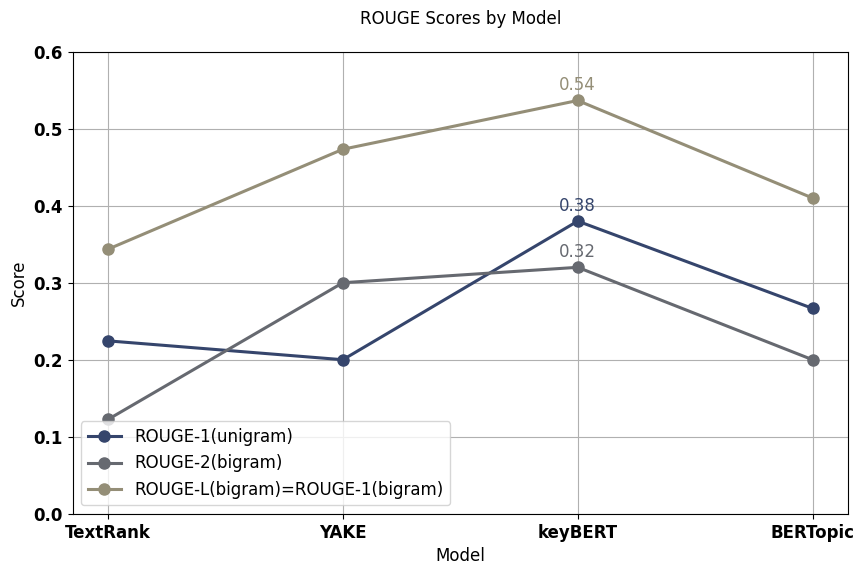

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 시각화
colors = sns.color_palette('cividis', n_colors=len(eval_result.columns))
column_names = {'rouge1_uni': 'ROUGE-1(unigram)', 'rouge2': 'ROUGE-2(bigram)',
                'rougeL': 'ROUGE-L(bigram)=ROUGE-1(bigram)'}
# 라인 그래프 그리기
plt.figure(figsize=(10, 6))
for i, column in enumerate(eval_result[['rouge1_uni','rouge2','rougeL']].columns):
  plt.plot(eval_result.index, eval_result[column], marker='o', markersize=8,
           linewidth=2.2, linestyle='-', color=colors[i], label=column_names[column])
  # 스코어마다 가장 높은 값에 레이블 추가
  max_value = eval_result[column].max()
  max_index = eval_result[column].idxmax()
  plt.text(max_index, max_value+0.008, f'{max_value:.2f}', fontsize=12,
            ha='center', va='bottom', color=colors[i])

# 그래프 설정
plt.title('ROUGE Scores by Model', pad=20)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0,0.6)
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.legend(fontsize=12)
plt.grid(True)

# 그래프 출력
plt.show()

## Topic Extraction

### TF-IDF
* sklearn 패키지를 이용해 `TF-IDF`기반 코사인 유사도 측정
* 이는 군집(토픽) 간 응집도를 나타내며, 응집도가 낮을수록(=분리도가 높을수록) 토픽 분리가 잘 됐다고 볼 수 있음
  * **TF** : topic에서 keyword가 등장하는 빈도
  * **DF** : keyword가 등장하는 topic 수
  * **IDF** : DF에 반비례하는 수(=등장하는 topic 수가 적을수록 소속된 topic과 종속성 강해질 것 =unique한 keyword일 확률 ↑)

    * --> 단순 계산한 결과는 모든 topic * 모든 keyword 조합들의 TF-IDF값을 담고 있음
    * --> 해당 topic에 없는 keyword들의 TF-IDF값까지 포함하니 당연히 평균이 낮아질 수밖에 없음
    * --> 실제 해당 topic에 있는 keyword들만 필터링해야 함

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# sentence, keyword, topic 매핑했던 감성 분석 데이터 load
roberta = pd.read_csv(file_path+'/file_name.csv')
roberta.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review_id,stars,sentence,compound_score,positive_score,neutral_score,negative_score,keywords_ug,keywords_bg,topic
0,1443659,5,Found 51st Deli on Uber Eats and we loved it!!!,0.989771,0.991007,0.007758,0.001236,uber,deli uber,service
1,1443659,5,I can't wait to check it out in person!,0.985175,0.986700,0.011776,0.001525,wait,check person,others
2,1044648,5,Love love love this place for HH n dinner is g...,0.989841,0.991794,0.006252,0.001954,dinner,dinner good,others
3,1044648,5,"Its ok for brunch, not as great as what people...",-0.041061,0.229077,0.500784,0.270139,brunch,brunch great,others
4,1044648,5,The Asian Nachos are the dish to get for HH.,0.397284,0.408822,0.579640,0.011538,nachos,asian nachos,food


In [ ]:
# 토픽별 키워드 리스트
topics = roberta['topic'].to_list()
food = roberta[roberta['topic'] == 'food']['keywords_bg'].to_list()
atmosphere = roberta[roberta['topic'] == 'atmosphere']['keywords_bg'].to_list()
service = roberta[roberta['topic'] == 'service']['keywords_bg'].to_list()
facility = roberta[roberta['topic'] == 'facility']['keywords_bg'].to_list()
price = roberta[roberta['topic'] == 'price']['keywords_bg'].to_list()
others = roberta[roberta['topic'] == 'others']['keywords_bg'].to_list()

In [ ]:
# 딕셔너리 형태로 만들기
topic_keywords = { 'food': food, 'service':service, 'atmosphere':atmosphere, 'facility': facility, 'price':price, 'others':others }

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# IDF 측정(전체 topic에서 단어가 등장하는 빈도가 낮을수록 좋은 것)
# 모든 토픽의 키워드를 문서로 취급
documents = {topic: ' '.join(keywords) for topic, keywords in topic_keywords.items()}

# TF-IDF 계산 (1-gram과 2-gram 포함)
tfidf_vectorizer_uni = TfidfVectorizer()  # 1gram
tfidf_vectorizer_bi = TfidfVectorizer(ngram_range=(1, 2))  # 2gram 고려
X_tfidf_uni = tfidf_vectorizer_uni.fit_transform(documents.values())
X_tfidf_bi = tfidf_vectorizer_bi.fit_transform(documents.values())

# TF-IDF DataFrame 생성
df_tfidf_uni = pd.DataFrame(X_tfidf_uni.toarray(), index=documents.keys(), columns=tfidf_vectorizer_uni.get_feature_names_out()) # unigram
df_tfidf_bi = pd.DataFrame(X_tfidf_bi.toarray(), index=documents.keys(), columns=tfidf_vectorizer_bi.get_feature_names_out())    # bigram

# DataFrame을 Long 형식으로 변형
df_uni_long = df_tfidf_uni.stack().reset_index()
df_uni_long.columns = ['Topic', 'Keyword', 'TF-IDF']
df_bi_long = df_tfidf_bi.stack().reset_index()
df_bi_long.columns = ['Topic', 'Keyword', 'TF-IDF']

# 결과 확인
display(df_uni_long)
print('\n')
display(df_bi_long)

,Topic,Keyword,TF-IDF
0,food,00,0.000412
1,food,000,0.000000
2,food,00am,0.000000
3,food,00pm,0.000000
4,food,03,0.000000
...,...,...,...
125191,others,zshechuan,0.000000
125192,others,zucchini,0.000499
125193,others,zushi,0.000250
125194,others,zushimaki,0.000250


,Topic,Keyword,TF-IDF
0,food,00,0.000404
1,food,00 25,0.000000
2,food,00 avocado,0.000000
3,food,00 awful,0.000000
4,food,00 breakfast,0.000197
...,...,...,...
1850323,others,zushimaki sunset,0.000000
1850324,others,zushimaki sushi,0.000000
1850325,others,zushimaki tried,0.000000
1850326,others,¼é,0.000000


In [ ]:
display(df_bi_long[df_bi_long['Keyword']=='prices'])
print('\n')
display(df_bi_long[df_bi_long['Keyword']=='uber'])
print('\n')
display(df_bi_long[df_bi_long['Keyword']=='pizza'])

,Topic,Keyword,TF-IDF
209933,food,prices,0.003060
518321,service,prices,0.002551
826709,atmosphere,prices,0.000446
1135097,facility,prices,0.002125
1443485,price,prices,0.592552
1751873,others,prices,0.017465


,Topic,Keyword,TF-IDF
287328,food,uber,0.000136
595716,service,uber,0.017552
904104,atmosphere,uber,0.000000
1212492,facility,uber,0.000000
1520880,price,uber,0.000000
1829268,others,uber,0.002063


,Topic,Keyword,TF-IDF
199425,food,pizza,0.222978
507813,service,pizza,0.011104
816201,atmosphere,pizza,0.005355
1124589,facility,pizza,0.007084
1432977,price,pizza,0.015362
1741365,others,pizza,0.069065


* 위 display된 결과들을 살펴보면,
  * `prices`는 `price` 토픽에서 가장 점수가 높고
  * `uber`는 배달과 관련된 `service` 토픽에서 가장 점수가 높으며
  * `pizza`는 `food` 토픽에서 가장 점수가 높음
* 대량의 keyword 조합들로 인해 TF-IDF 값 자체는 낮으니 RANK화 해서 살펴보고자 함
  * (e. g.) `pizza`는 `food` 토픽에서 1등, `others`에서 2등, `price`에서 3등...  
  * 해당 topic에서 점수가 가장 높은(RANK=1) keyword들이 전체 keyword 중 몇 %를 차지하는지 살펴보고자 함

In [ ]:
# 본 프로젝트는 bigram 위주로 진행하였으니 bigram 기준으로 TF-IDF 계산
df_bi_pivot = df_bi_long.pivot_table(index='Keyword', columns='Topic', values='TF-IDF')
df_bi_pivot = df_bi_pivot.replace(0, np.nan) # 0은 nan으로 바꿔주기
df_bi_pivot_rank = df_bi_pivot.apply(lambda x : x.rank(ascending=False, method='min'), axis=1).reset_index()
df_bi_pivot_rank

Topic,Keyword,atmosphere,facility,food,others,price,service
0,00,NaN,3.0,5.0,2.0,1.0,4.0
1,00 25,NaN,NaN,NaN,NaN,1.0,NaN
2,00 avocado,NaN,NaN,NaN,NaN,1.0,NaN
3,00 awful,NaN,1.0,NaN,NaN,NaN,NaN
4,00 breakfast,NaN,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
308383,zushimaki sunset,NaN,NaN,1.0,NaN,NaN,NaN
308384,zushimaki sushi,NaN,NaN,1.0,NaN,NaN,NaN
308385,zushimaki tried,NaN,NaN,1.0,NaN,NaN,NaN
308386,¼é,NaN,NaN,1.0,NaN,NaN,NaN


In [ ]:
# 각 토픽별로 비율을 계산하고 DataFrame에 추가
result_df= pd.DataFrame()

for topic, keywords in topic_keywords.items():
    # 토픽별로 DataFrame 필터링
    df = df_bi_pivot_rank[(df_bi_pivot_rank[topic].notna()) & (df_bi_pivot_rank['Keyword'].isin(keywords))]

    # Ratio 계산
    ratio = df.apply(lambda x: (x == 1).sum()) / len(df)

    # DataFrame에 컬럼 추가
    result_df[topic] = ratio

result_df = result_df.reset_index()
result_df.columns = ['Keyword'] + list(result_df.columns[1:])
result_df = result_df.drop(0, axis=0) # 첫 번째 행은 무관하므로 drop

# 행순서 바꾸기
order = ['food', 'service', 'atmosphere', 'facility', 'price', 'others']
result_df = result_df.rename({'Keyword':'Topic'}, axis=1)
result_df['Topic'] = pd.Categorical(result_df['Topic'], categories=order, ordered=True)
result_df = result_df.sort_values('Topic').reset_index(drop=True)
result_df

,Topic,food,service,atmosphere,facility,price,others
0,food,0.903683,0.014098,0.007224,0.007366,0.009103,0.029355
1,service,0.011492,0.895855,0.005418,0.004003,0.001821,0.033394
2,atmosphere,0.007937,0.012243,0.906194,0.024500,0.002276,0.027714
3,facility,0.006389,0.016165,0.036120,0.938671,0.004096,0.020887
4,price,0.004710,0.006466,0.002550,0.003843,0.945835,0.008256
5,others,0.065789,0.055173,0.042494,0.021617,0.036868,0.880394


In [ ]:
# pandas styler로 간단히 히트맵 확인
result_df.set_index('Topic').style.background_gradient(cmap='Blues')

,food,service,atmosphere,facility,price,others
Topic,,,,,,
food,0.903683,0.014098,0.007224,0.007366,0.009103,0.029355
service,0.011492,0.895855,0.005418,0.004003,0.001821,0.033394
atmosphere,0.007937,0.012243,0.906194,0.024500,0.002276,0.027714
facility,0.006389,0.016165,0.036120,0.938671,0.004096,0.020887
price,0.004710,0.006466,0.002550,0.003843,0.945835,0.008256
others,0.065789,0.055173,0.042494,0.021617,0.036868,0.880394


### Cosine Similarity

* 위에까지는 TF-IDF값만 구한 거고, 이걸 기반으로 코사인유사도도 구해보자.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# TF-IDF 벡터 행렬을 추출 (위에서 bigram 기준으로 추출한 TF-IDF)
X_tfidf_matrix = X_tfidf_bi

# 코사인 유사도 계산
cosine_sim = cosine_similarity(X_tfidf_matrix, X_tfidf_matrix)

# 결과를 DataFrame으로 변환 (토픽 이름을 인덱스와 컬럼으로 사용)
cosine_sim_df = pd.DataFrame(cosine_sim, index=documents.keys(), columns=documents.keys())
cosine_sim_df

,food,service,atmosphere,facility,price,others
food,1.000000,0.180705,0.146273,0.108284,0.172343,0.509881
service,0.180705,1.000000,0.140346,0.099016,0.077909,0.300171
atmosphere,0.146273,0.140346,1.000000,0.322412,0.072641,0.515383
facility,0.108284,0.099016,0.322412,1.000000,0.046357,0.279102
price,0.172343,0.077909,0.072641,0.046357,1.000000,0.209480
others,0.509881,0.300171,0.515383,0.279102,0.209480,1.000000


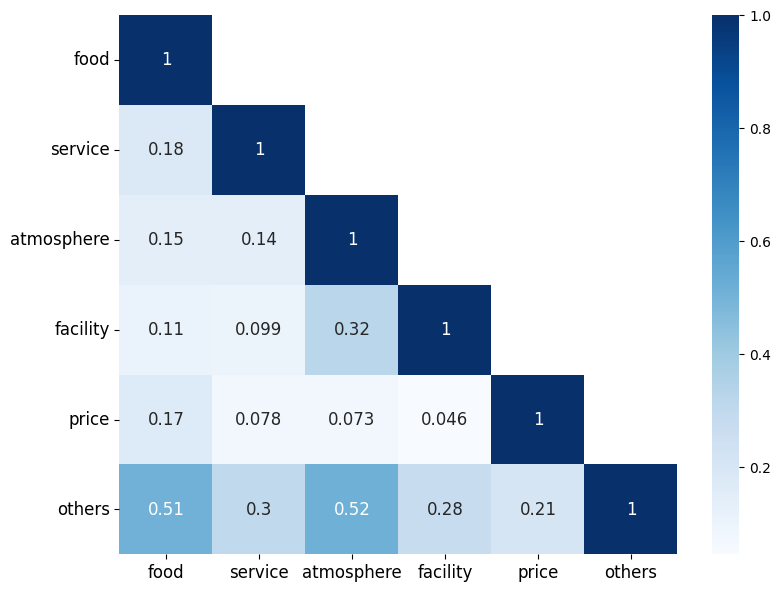

In [ ]:
# 대각선 및 하삼각 행렬만 포함하도록 필터
lower_df = cosine_sim_df.where(np.tril(np.ones_like(cosine_sim_df, dtype=bool)))

# 시각화
plt.figure(figsize=(9, 7))
sns.heatmap(data=lower_df,annot=True,annot_kws={'size': 12}, cmap='Blues')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.show()

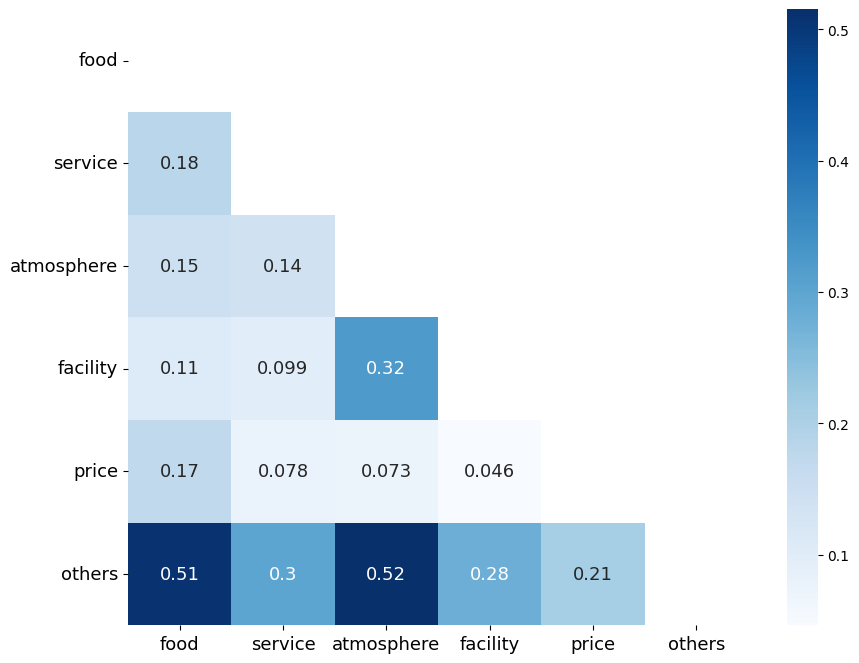

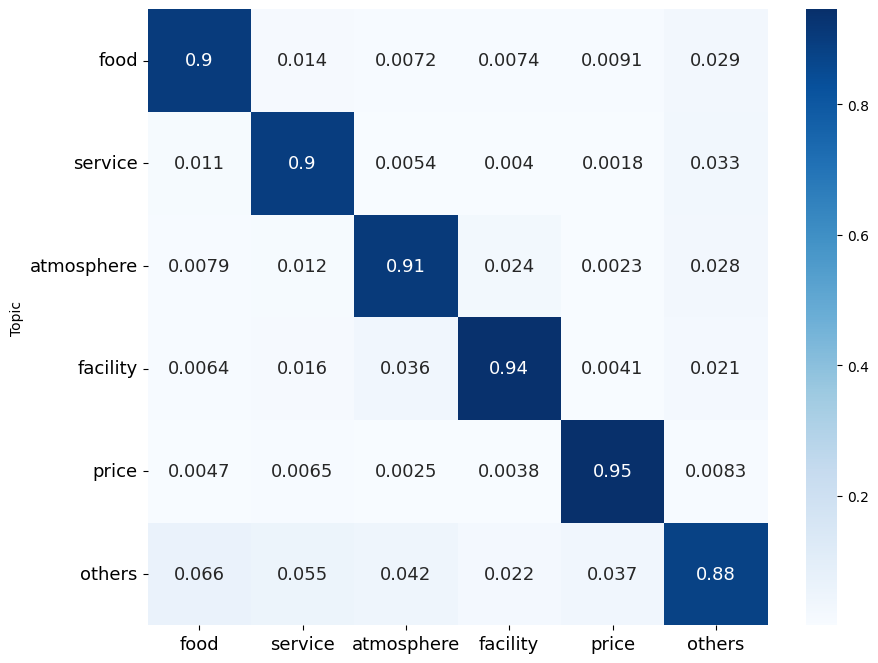

In [ ]:
# 위에서 구한 TF-IDF, cosine similarity 결과 일괄 시각화

# 대각선 값들
mask = np.triu(np.ones_like(cosine_sim_df, dtype=bool))
plt.figure(figsize=(10, 8))
ax = sns.heatmap(data=cosine_sim_df, annot=True, annot_kws={'size': 13}, mask=mask, cmap='Blues', cbar=True,
                 xticklabels=cosine_sim_df.columns, yticklabels=cosine_sim_df.index)
# 축 레이블 회전 제거
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
plt.show()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(data=result_df.set_index('Topic'), annot=True, annot_kws={'size': 13}, cmap='Blues', cbar=True,
                 xticklabels=cosine_sim_df.columns, yticklabels=cosine_sim_df.index)
# 축 레이블 회전 제거
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
plt.show()

## Cohearance
* `gensim` 및 `pyLDAvis` 패키지 이용
* keyword들 간 최적의 topic 개수와 함께 co-herence를 측정
* co-herence가 높을수록 topic 분류가 잘 됐다고 볼 수 있음

In [ ]:
!pip install gensim pyLDAvis nltk
clear_output()

### Function

In [ ]:
import gensim
import gensim.corpora as corpora
import gensim.models.ldamodel as ldamodel
from gensim.models import CoherenceModel, Phrases
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# NLTK의 stopwords 다운로드
nltk.download('stopwords')
nltk.download('punkt')
clear_output()

In [ ]:
# 텍스트 전처리
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))  # 영어 불용어 처리
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

# try1) 딕셔너리와 문서-단어 행렬 생성
def create_corpus_and_dictionary(topic_keywords, below=None, freq=None):
    documents = []
    for topic, keywords in topic_keywords.items():
        doc = " ".join(keywords)
        documents.append(doc)

    processed_docs = [preprocess_text(doc) for doc in documents]
    id2word = corpora.Dictionary(processed_docs)
    if below is not None and freq is not None:
      id2word.filter_extremes(no_below=below, no_above=freq)
    elif below is not None:
      id2word.filter_extremes(no_below=2)
    elif freq is not None:
      id2word.filter_extremes(no_above=freq)
    corpus = [id2word.doc2bow(doc) for doc in processed_docs]
    return corpus, id2word, processed_docs

# try2) biagram 문서-단어 행렬 생성
def create_corpus_and_dictionary_with_bigrams(topic_keywords, below=None, freq=None):
    # 문서 생성
    documents = []
    for topic, keywords in topic_keywords.items():
        doc = " ".join(keywords)
        documents.append(doc)

    # 2-gram 생성
    texts = [preprocess_text(doc) for doc in documents]
    bigram_model = Phrases(texts, min_count=2, threshold=2)  # bigram 생성
    bigrams = [bigram_model[doc] for doc in texts]  # n-gram이 적용된 문서

    # Dictionary와 Corpus 생성
    id2word = corpora.Dictionary(bigrams)
    if below is not None and freq is not None:
      id2word.filter_extremes(no_below=below, no_above=freq)
    elif below is not None:
      id2word.filter_extremes(no_below=2)
    elif freq is not None:
      id2word.filter_extremes(no_above=freq)
    corpus = [id2word.doc2bow(doc) for doc in bigrams]
    return corpus, id2word, bigrams, bigram_model

# LDA 모델 학습
def train_lda_model(corpus, id2word, num_topics=6):
    lda_model = ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=15)
    return lda_model

# 코히어런스 측정 함수
def compute_coherence(lda_model, corpus, id2word, texts, coherence_type='c_v'):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence=coherence_type)
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [ ]:
# coherence 추출 코드 절차
corpus, id2word, processed_docs = create_corpus_and_dictionary(topic_keywords, below=2)   # 문서-단어 행렬과 사전 생성
lda_model = train_lda_model(corpus, id2word)  # LDA 모델 학습
topic_coherence = compute_coherence(lda_model, corpus, id2word, processed_docs)  # 전체 토픽의 코히어런스 측정
topic_coherence

0.5497369264072071

In [ ]:
# 위 절차 및 함수들 간단히 통합
def total_coherence(create_corpus_and_dictionary, topic_keywords, below=None, freq=None): # corpus 생성 모델, coherence 측정할 문서, corpus 필터링 조건
    corpus, id2word, processed_docs = create_corpus_and_dictionary(topic_keywords, below, freq)   # 문서-단어 행렬과 사전 생성
    lda_model = train_lda_model(corpus, id2word)  # LDA 모델 학습
    topic_coherence = compute_coherence(lda_model, corpus, id2word, processed_docs)  # 전체 토픽의 코히어런스 측정
    return topic_coherence

In [ ]:
topic_coherence = total_coherence(create_corpus_and_dictionary, topic_keywords, below=2)
print(f"전체 토픽의 코히어런스: {topic_coherence}")

전체 토픽의 코히어런스: 0.6213031796679803


In [ ]:
# test
topic_coherence = total_coherence(create_corpus_and_dictionary, topic_keywords) # 기본 세팅
print(f"전체 토픽의 코히어런스 / 빈도 제거 없을 때 : {topic_coherence}")

topic_coherence = total_coherence(create_corpus_and_dictionary, topic_keywords, freq=0.5) # 50% 이상 빈도를 가진 keyword는 제외
print(f"전체 토픽의 코히어런스 / 빈도 50% 제거 : {topic_coherence}")

topic_coherence = total_coherence(create_corpus_and_dictionary, topic_keywords, freq=0.4) # 40% 이상 빈도를 가진 keyword는 제외
print(f"전체 토픽의 코히어런스 / 빈도 40% 제거 : {topic_coherence}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


전체 토픽의 코히어런스 / 빈도 제거 없을 때 : 0.6213487545699258
전체 토픽의 코히어런스 / 빈도 50% 제거 : 0.557191062973399
전체 토픽의 코히어런스 / 빈도 40% 제거 : 0.5370685100881142


### Number of Topics
* 최적의 topic 개수 확인

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


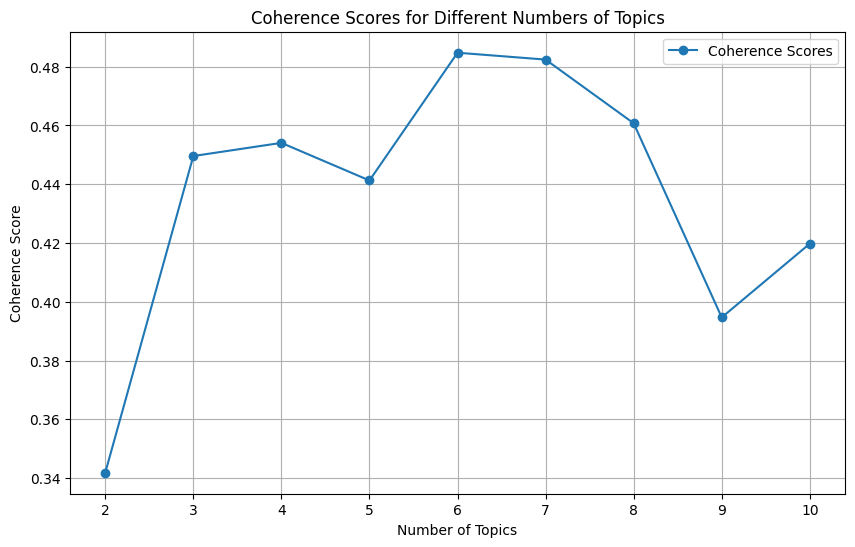

In [ ]:
# 코히어런스 값을 계산하는 함수
def compute_coherence_values(dictionary, corpus, texts, start, limit, step, passes=15, iterations=100):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit + 1, step):
        # LDA 모델 학습
        model = gensim.models.LdaModel(
            corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes,       # 패스 수 조정
            iterations=iterations,  # 반복 횟수 조정
            random_state=42)     # 랜덤 시드 설정 (재현성
        model_list.append(model)

        # CoherenceModel 생성 및 코히어런스 점수 계산
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

# 최적의 토픽 개수를 찾고 시각화하는 함수
def find_optimal_number_of_topics(dictionary, corpus, processed_data):
    start = 2
    limit = 10
    step = 1
    passes = 15    # 패스 수 설정
    iterations = 100  # 반복 횟수 설정

    model_list, coherence_values = compute_coherence_values(
        dictionary=dictionary, corpus=corpus, texts=processed_data, start=start,
        limit=limit, step=step, passes=passes, iterations=iterations)

    # 시각화
    x = range(start, limit + 1, step)
    plt.figure(figsize=(10, 6))
    # 코히어런스 값 레이블 추가
    for i, cv in enumerate(coherence_values):
      plt.text(x[i], cv+0.003, f'{cv:.3f}', fontsize=12, ha='center')
    plt.plot(x, coherence_values, marker='o', color='steelblue')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Number of Topics", fontsize=14)
    plt.ylabel("Coherence Score", fontsize=14)
    plt.title("Coherence Scores for Different Numbers of Topics",fontsize=16)
    plt.legend(["Coherence Scores"], loc='best')
    plt.grid(True)
    plt.show()

# 문서-단어 행렬과 사전 생성
corpus, id2word, processed_docs = create_corpus_and_dictionary(topic_keywords)

# 최적의 토픽 개수 찾기 및 시각화
find_optimal_number_of_topics(id2word, corpus, processed_docs)

### Visualization
* 확률기반 모델이므로 최적의 시각화를 위해 여러 번 test 필요

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# pyLDAvis를 사용하여 LDA 모델 시각화
corpus, id2word, processed_docs, bg_model = create_corpus_and_dictionary_with_bigrams(topic_keywords, freq=0.7)   # 문서-단어 행렬과 사전 생성
lda_model = train_lda_model(corpus, id2word)  # LDA 모델 학습

processed_docs = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(processed_docs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# HTML 파일로 저장
pyLDAvis.save_html(processed_docs, 'lda_visualization_bigram.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---
# Intrinsic Evaluation
* keyword 추출과 topic 추출에 대한 결과는 '잘 요약/분류 되었는지' 관점에서 사람의 주관이 개입될 수 밖에 없음
* 팀원들과 함께 5점 척도 기준 평가 진행
  * 1) unigram과 bigram 간 요약 성능 차이
  * 2) 추출된 keyword가 해당 topic에 잘 분류되었는지


In [ ]:
# 인당 review 10개씩 평가하도록 감성분석 데이터에서 랜덤 샘플링
evaluate_id = review.sample(n=40, random_state=42)['review_id'].to_list()
evaluate_df = roberta[roberta['review_id'].isin(evaluate_id)]

# 공유 Sheet에서 평가 진행하기 위해 저장
file_path = '/your_path'
evaluate_df.to_csv(file_path+'/file_name.csv', index=False)

### Result

In [ ]:
# 평가 결과 df화
data = {
    'Topic': ['food', 'service', 'atmosphere', 'facility', 'price', 'others', 'total'],
    'Average_Unigram': [3.4, 3.520833333, 3.727272727, 3, 3.6, 3.391752577, 3.418118467],
    'Average_Bigram': [3.747826087, 3.708333333, 4.636363636, 3.090909091, 3.6, 3.618556701, 3.703832753],
    'Average_Topic': [4.4, 4.375, 4.272727273, 2.727272727, 4.8, 3.721649485, 4.104529617]
}

df = pd.DataFrame(data)
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Average_Unigram,Average_Bigram,Average_Topic
0,food,3.400000,3.747826,4.400000
1,service,3.520833,3.708333,4.375000
2,atmosphere,3.727273,4.636364,4.272727
3,facility,3.000000,3.090909,2.727273
4,price,3.600000,3.600000,4.800000
5,others,3.391753,3.618557,3.721649
6,total,3.418118,3.703833,4.104530


### Visualization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


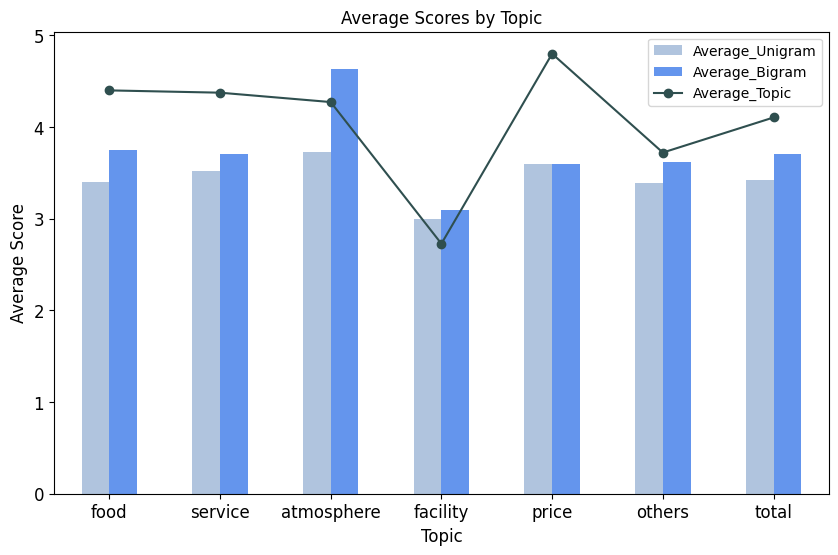

In [ ]:
# 막대그래프 생성 (Average_Unigram, Average_Bigram)
ax = df.plot(x='Topic', y=['Average_Unigram', 'Average_Bigram'], kind='bar',
             color=['lightsteelblue','cornflowerblue'], figsize=(10, 6))

# Average_Topic 라인 그래프로 추가
df.plot(x='Topic', y='Average_Topic', kind='line', color='darkslategrey', marker='o', ax=ax)

# 제목 및 레이블 설정
plt.title('Average Scores by Topic', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Average Score', fontsize=12)

plt.show()